In [526]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [527]:
# set random seeds for reproducability
seed = 42
np.random.seed(seed=seed)
_ = torch.manual_seed(seed=seed)

In [528]:
# plot settings
plt.style.use('fivethirtyeight')

## Constants and Hyperparameters

In [529]:
epochs = 10
batch_size = 4

hidden_size = 64
learning_rate = 0.0001

## Creating a Syntethic Time-Series Dataset

In [530]:
N = 1000   # number of data points
mu = 0      # mu of normal distribution 
sigma = 0.4   # sigma^2 of normal distribution   
noise = np.random.normal(mu, sigma, size=N) # normal dist. noise

X_sequence = np.sin(np.linspace(0, 30, N)) + noise

print(f'Shape of X_sequence: {X_sequence.shape}')

Shape of X_sequence: (1000,)


#### Plotting the Sequence aginst Time

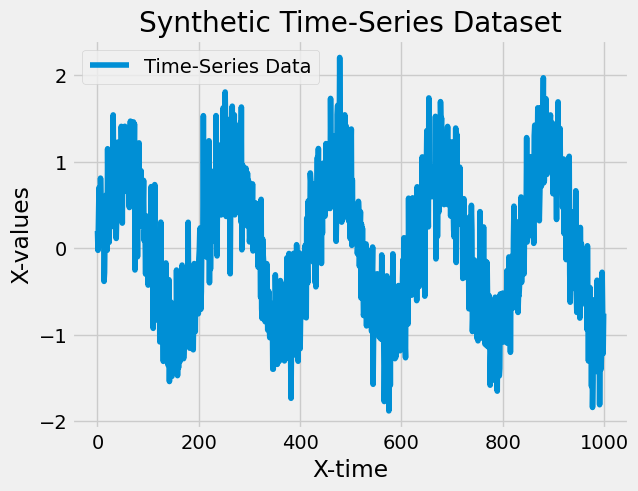

In [531]:
_, ax = plt.subplots(nrows=1, ncols=1)

ax.set_title('Synthetic Time-Series Dataset')
ax.plot(X_sequence, label='Time-Series Data')
ax.set_xlabel('X-time')
ax.set_ylabel('X-values')
ax.legend()
plt.show()

#### Create Timestamps

In [532]:
seq_len = 4
X_, Y_ = [], []

# pytorch RNN wants input of shape [batch_size, seq_len, num_features]
for i in range(0, N - seq_len):
    X_.append(X_sequence[i:i + seq_len].reshape(seq_len, 1)) # num_features = 1
    Y_.append(X_sequence[i+seq_len])
X = np.stack(X_)
Y = np.stack(Y_).reshape(-1, 1)
print(f'Shape of X: {X.shape}')
print(f'Shape of Y: {Y.shape}')

Shape of X: (996, 4, 1)
Shape of Y: (996, 1)


In [533]:
print(X[:4])
print(Y[:4])

[[[ 0.19868566]
  [-0.0252802 ]
  [ 0.31909937]
  [ 0.69918022]]

 [[-0.0252802 ]
  [ 0.31909937]
  [ 0.69918022]
  [ 0.02617011]]

 [[ 0.31909937]
  [ 0.69918022]
  [ 0.02617011]
  [ 0.05593181]]

 [[ 0.69918022]
  [ 0.02617011]
  [ 0.05593181]
  [ 0.81089197]]]
[[0.02617011]
 [0.05593181]
 [0.81089197]
 [0.51563938]]


#### Splitting for Training and Test Set

In [534]:
N = X.shape[0]
train_size = 0.7
N_train = int(train_size * N)
X_train, y_train = X[:N_train], Y[:N_train]
X_test, y_test = X[N_train:], Y[N_train:]

# setting up time axis for plotting
time_train = range(0, len(X_train))
time_test = range(len(X_train), len(X_train) + len(X_test))

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (697, 4, 1)
Shape of y_train: (697, 1)
Shape of X_test: (299, 4, 1)
Shape of y_test: (299, 1)


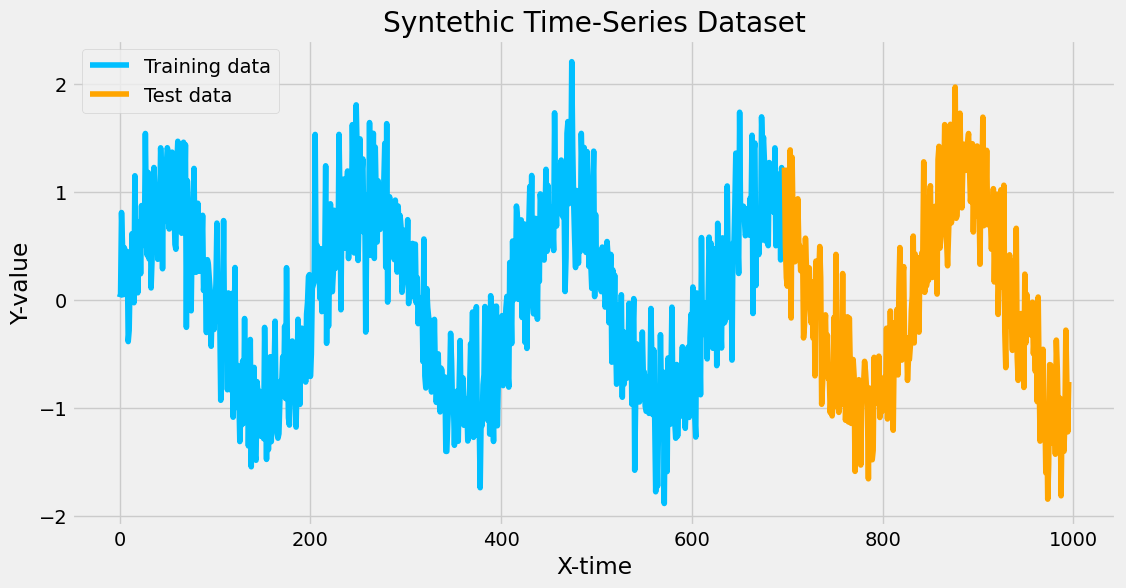

In [535]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.set_title('Syntethic Time-Series Dataset')
ax.plot(time_train, y_train, label='Training data', color='deepskyblue')
ax.plot(time_test, y_test, label='Test data', color='orange')
ax.set_xlabel('X-time')
ax.set_ylabel('Y-value')
ax.legend()
plt.show()

#### Transform NumPy Arrays to PyTorch Tensor Datasets and Load them into a Dataloader

In [536]:
train_set = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

dataloader_train = DataLoader(train_set, shuffle=False, batch_size=batch_size)
dataloader_test = DataLoader(test_set, shuffle=False, batch_size=batch_size)

#### Training and Evaluation

In [537]:
def train(
        model: nn.Module,
        dataloader: DataLoader,
        verbose: bool=False
        ) -> None:

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs):
        total_loss = 0.0
        for input, target in dataloader:
            optimizer.zero_grad()
            pred = model(input)
            loss = criterion(pred, target)
            total_loss += loss.item() * input.size(0)
            loss.backward()
            optimizer.step()
        if verbose:
            total_loss = total_loss / len(dataloader)
            print(f'epoch: {epoch}\tmse: {total_loss}')


def evaluate(
        model: nn.Module,
        dataloader: DataLoader,
    ) -> tuple:
    N = len(dataloader)
    mse = 0.0
    pred_all = []
    target_all = []
    with torch.no_grad():
        for input, target in dataloader:
            pred = model(input)
            pred_all.append(pred) 
            target_all.append(target) 
            loss = torch.sum((target - pred)**2)
            mse += loss.item()
    pred_all = torch.concatenate(pred_all, dim=0)
    target_all = torch.concatenate(target_all, dim=0)
    
    # Evaluate performance 
    pred_mean = torch.mean(pred_all) 
    r2_score = torch.sum((pred_all - pred_mean)**2) / torch.sum((target_all - pred_mean)**2) 
    mse = mse / N
    rmse = (mse**0.5) / N
    return pred_all, mse, rmse, r2_score


#### Creating the RNN

In [538]:
class SimpleRNN(nn.Module):
    def __init__(
            self,
            input_size: int,
            hidden_size: int,
            output_size: int
            ) -> None:
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=1)
        self.fc = nn.Linear(hidden_size, output_size) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x, _ = self.rnn(x)              # [N, seq_len, hidden_size]
        x = self.fc(x[:, -1, :])
        return x

In [539]:
input_size = 1
hidden_size = 64
output_size = 1

model = SimpleRNN(input_size, hidden_size, output_size)
train(model, dataloader_train, verbose=True)
preds_train, mse_train, rmse_train, r2_train = evaluate(model, dataloader_train)
preds_test, mse_test, rmse_test, r2_test = evaluate(model, dataloader_test)

y_pred_train = preds_train.numpy()
y_pred_test = preds_test.numpy()

epoch: 0	mse: 2.199740178712777
epoch: 1	mse: 1.2004370545396315
epoch: 2	mse: 0.820682100698884
epoch: 3	mse: 0.8098500165130411
epoch: 4	mse: 0.8067708280363253
epoch: 5	mse: 0.8040701366961003
epoch: 6	mse: 0.8016959521706615
epoch: 7	mse: 0.7996174396574497
epoch: 8	mse: 0.7977999832268272
epoch: 9	mse: 0.7962089440173337


In [ ]:
print(f'Eval (train) - mse: {mse_train}\t')
print(f'Eval (test)  - ')

In [541]:
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_pred_train: {y_pred_train.shape}\n')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')
print(f'Shape of y_pred_test: {y_pred_test.shape}')

Shape of X_train: (697, 4, 1)
Shape of y_train: (697, 1)
Shape of y_pred_train: (697, 1)

Shape of X_test: (299, 4, 1)
Shape of y_test: (299, 1)
Shape of y_pred_test: (299, 1)


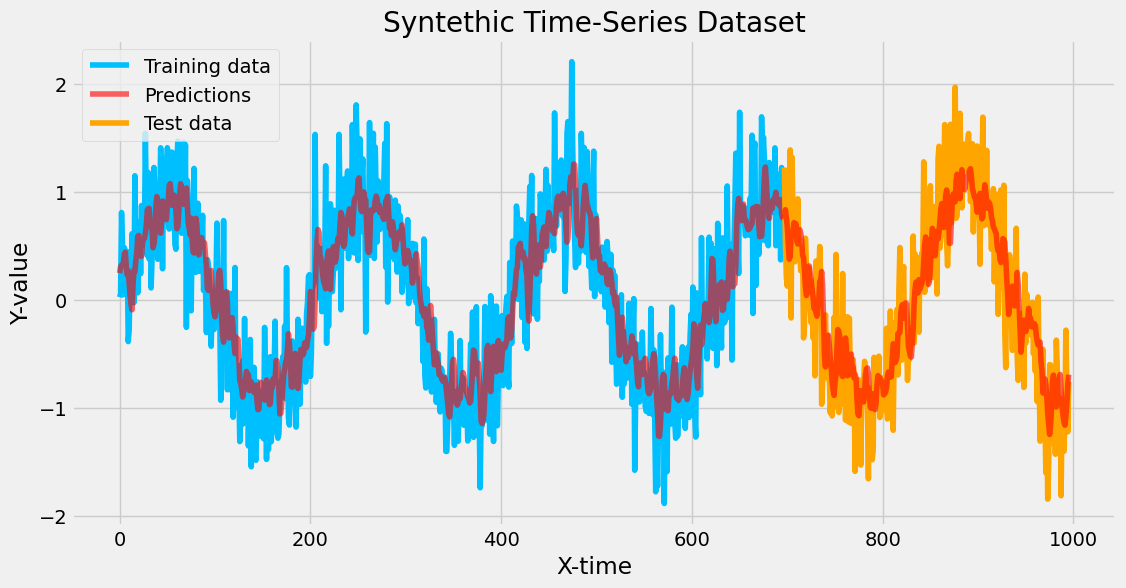

In [542]:
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
ax.set_title('Syntethic Time-Series Dataset')
ax.plot(time_train, y_train, label='Training data', color='deepskyblue')
ax.plot(time_train, y_pred_train, label='Predictions', color='red', alpha=0.6)

ax.plot(time_test, y_test, label='Test data', color='orange')
ax.plot(time_test, y_pred_test, color='red', alpha=0.6)
ax.set_xlabel('X-time')
ax.set_ylabel('Y-value')
ax.legend()
plt.show()